Shyam Akhil Nekkanti - 8982123

Jun He (Helena) - 8903073

Zheming Li (Brendan) - 8914152

Summary

We are analysing what factors influence a video's persistence within YouTube's trending tab. We are considering metrics like (views, likes, dislikes, comments) and their daily changes over time. 

Each entry represents a daily snapshot of trending videos, 

Previous analysis shows different video categories show distinct patterns in their trending lifecycles, with some categories maintaining trending status longer than others.

Research Question
Can we predict the number of days a video will remain on the trending tab? (number of days between 1 - 30 )

Hypothesis
 
Null Hypothesis H0: Early engagement has no significant correlation with trending duration.
 
Alternative Hypothesis H1: Higher early engagement predicts longer trending durations.

Engagement - (views, likes, dislikes, comments, etc)
 
Testing Method - Multiple regression analysis

In [27]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression

class YouTubeAnalysis:
    def __init__(self, csv_file, json_file):
        self.csv_file = csv_file
        self.json_file = json_file
        self.df = None
        
    def load_data(self):
        # Load the category mapping for US videos
        with open(self.json_file, 'r') as f:
            categories = json.load(f)
            self.category_map = {int(item['id']): item['snippet']['title'] 
                               for item in categories['items']}
        
        # Load and sort by video_id and trending_date
        self.df = pd.read_csv(self.csv_file)
        self.df['trending_date'] = pd.to_datetime(self.df['trending_date'], format='%y.%d.%m')
        self.df = self.df.sort_values(['video_id', 'trending_date'])
        
        # Add category names
        self.df['category_name'] = self.df['category_id'].map(self.category_map)
        
        # Get number of appearances for each video
        video_counts = self.df.groupby('video_id').size()
        self.df['trending_duration'] = self.df['video_id'].map(video_counts)
        
        # Calculate daily changes
        self.df['views_change'] = self.df.groupby('video_id')['views'].diff()
        self.df['likes_change'] = self.df.groupby('video_id')['likes'].diff()
        self.df['dislikes_change'] = self.df.groupby('video_id')['dislikes'].diff()
        self.df['comment_change'] = self.df.groupby('video_id')['comment_count'].diff()
        
        # First day metrics are set to 0
        self.df['views_change'] = self.df['views_change'].fillna(0)
        self.df['likes_change'] = self.df['likes_change'].fillna(0)
        self.df['dislikes_change'] = self.df['dislikes_change'].fillna(0)
        self.df['comment_change'] = self.df['comment_change'].fillna(0)
        
        # Calculate daily totals for time series analysis
        self.daily_totals = self.df.groupby('trending_date').agg({
            'views': 'sum',
            'likes': 'sum',
            'dislikes': 'sum',
            'comment_count': 'sum'
        }).reset_index()
        
        # Sort by date
        self.daily_totals = self.daily_totals.sort_values('trending_date')
        
        # Calculate moving averages
        for metric in ['views', 'likes', 'dislikes', 'comment_count']:
            # 7-day moving average
            self.daily_totals[f'{metric}_MA7'] = self.daily_totals[metric].rolling(window=7).mean()
            # 30-day moving average
            self.daily_totals[f'{metric}_MA30'] = self.daily_totals[metric].rolling(window=30).mean()

        # FEATURES WE ARE ANALYSING
        self.features = ['views', 'likes', 'dislikes', 'comment_count',
                        'views_change', 'likes_change', 'dislikes_change', 
                        'comment_change', 'trending_duration']
        
    def plot_time_series(self, metric='views'):
        plt.figure(figsize=(12, 6))
        self.daily_totals[metric].plot(label=f'Daily {metric}', alpha=0.5)
        self.daily_totals[f'{metric}_MA7'].plot(label=f'7-day MA', linewidth=2)
        self.daily_totals[f'{metric}_MA30'].plot(label=f'30-day MA', linewidth=2)
        
        plt.title(f'Daily Total {metric.capitalize()} with Moving Averages')
        plt.xlabel('Date')
        plt.ylabel(f'Total {metric.capitalize()}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
class DimensionalityReduction:
    def __init__(self, df, features):
        self.df = df
        self.features = features
              
    def missing_values_ratio(self, threshold=0.5):
        missing_ratio = self.df[self.features].isnull().mean()
        return list(missing_ratio[missing_ratio < threshold].index)
    
    def low_variance_filter(self, threshold=0.01):
        variances = self.df[self.features].var()
        return list(variances[variances > threshold].index)
    
    def high_correlation_filter(self, threshold=0.95):
        corr = self.df[self.features].corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
        return [col for col in self.features if col not in to_drop]
    
    def pca_analysis(self, n_components=0.95):
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(self.df[self.features])
        
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(scaled_data)
        return pca_result, pca.explained_variance_ratio_
    
    def random_forest_importance(self, target='trending_duration'):
        features = [f for f in self.features if f != target]
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(self.df[features], self.df[target])
        return dict(zip(features, rf.feature_importances_))
    
    def forward_selection(self, target='trending_duration', k=3):
        features = [f for f in self.features if f != target]
        selector = SelectKBest(f_regression, k=k)
        selector.fit(self.df[features], self.df[target])
        selected = [features[i] for i in range(len(features)) 
                   if selector.get_support()[i]]
        return selected    

In [28]:
analysis = YouTubeAnalysis('youtube-dataset/USvideos.csv', 
                          'youtube-dataset/US_category_id.json')
analysis.load_data()

dim_red = DimensionalityReduction(analysis.df, analysis.features)

# Missing Values Analysis
print("Features after missing values filter:")
print(dim_red.missing_values_ratio())

# Low Variance Filter
print("\nFeatures after variance filter:")
print(dim_red.low_variance_filter())

# Correlation Filter
print("\nFeatures after correlation filter:")
print(dim_red.high_correlation_filter())

# PCA
pca_result, explained_var = dim_red.pca_analysis()
print("\nPCA variance ratios:")
print(explained_var)

# Random Forest Importance
print("\nRandom Forest feature importance:")
print(dim_red.random_forest_importance())

# Forward Selection
print("\nSelected features from forward selection:")
print(dim_red.forward_selection())

Features after missing values filter:
['views', 'likes', 'dislikes', 'comment_count', 'views_change', 'likes_change', 'dislikes_change', 'comment_change', 'trending_duration']

Features after variance filter:
['views', 'likes', 'dislikes', 'comment_count', 'views_change', 'likes_change', 'dislikes_change', 'comment_change', 'trending_duration']

Features after correlation filter:
['views', 'likes', 'dislikes', 'comment_count', 'views_change', 'likes_change', 'dislikes_change', 'comment_change', 'trending_duration']

PCA variance ratios:
[0.49802791 0.16311569 0.11280834 0.09951531 0.05511579 0.03328016]

Random Forest feature importance:
{'views': 0.34842192123576476, 'likes': 0.12633422980050185, 'dislikes': 0.11857425185690296, 'comment_count': 0.1270059370003548, 'views_change': 0.10175097076661607, 'likes_change': 0.06103083597327413, 'dislikes_change': 0.05096730632713933, 'comment_change': 0.06591454703944614}

Selected features from forward selection:
['views', 'likes', 'comment

All nine features (four static metrics, four derived change metrics, and the trending duration) passed every reduction test

they showed no significant missing values, 
showed meaningful variance above the threshold
and maintained correlation coefficients below 0.95. 

This suggests the dataset features all contribute unique and significant information.

We find that views are the strongest predictor (34.8% importance), followed by comments (12.7%) and likes (12.6%). This suggests that viewership is the primary driver of trending duration. These three features are the best predictors of video performance in the trending tab that we have available.

- Static metrics are more important than their daily changes



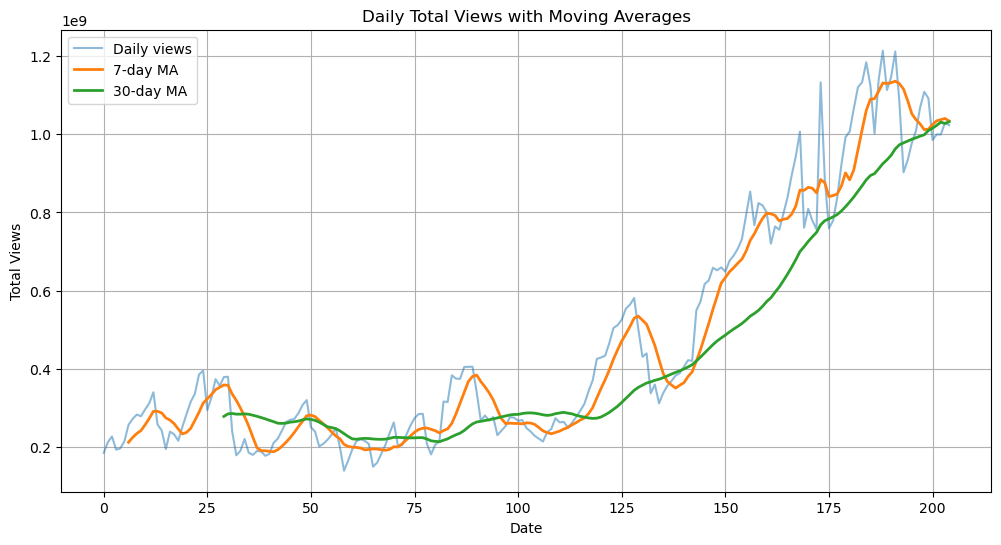

In [29]:
# Plot time series for chosen features
for metric in ['views']:
    analysis.plot_time_series(metric)

### Moving Averages Analysis

The moving averages plot provides additional insights:

1. The 7-day moving average smooths out the weekly fluctuations, revealing the short-term trend more clearly.
2. The 30-day moving average further smooths the series, highlighting the longer-term trend of increasing views.

3. The gap between the daily views and the moving averages appears to widen over time, suggesting increasing volatility.

### Nature of the Time Series data

This time series appears to be multiplicative rather than additive.

1. The amplitude of fluctuations increase over time, proportional to the overall views
2. The widening gap between daily views and moving averages as the views increase.

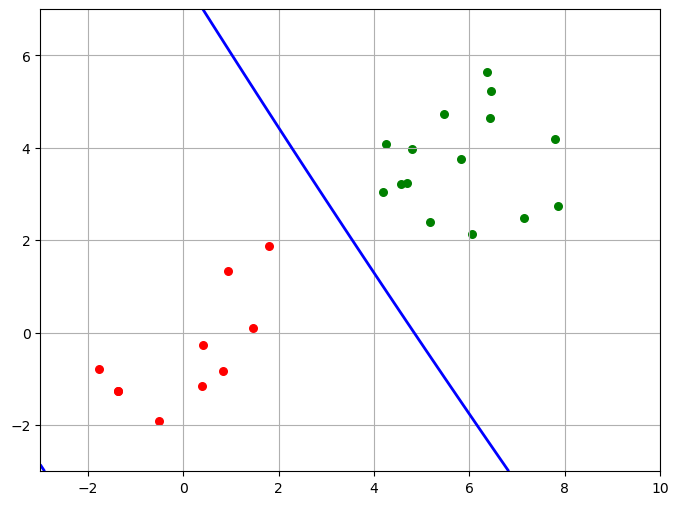

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Approximate data points from image
np.random.seed(42)

# Create red points (left bottom)
red_x = np.random.uniform(-2, 2, 10)
red_y = np.random.uniform(-2, 2, 10)
red_points = np.column_stack([red_x, red_y])

# Create green points (right top)
green_x = np.random.uniform(4, 8, 15)
green_y = np.random.uniform(2, 6, 15)
green_points = np.column_stack([green_x, green_y])

# Combine data
X = np.vstack([red_points, green_points])
y = np.array([-1]*len(red_points) + [1]*len(green_points))

# Fit SVM with quadratic kernel and large C
svm = SVC(kernel='poly', degree=2, C=2)  # Large C value
svm.fit(X, y)

# Create grid to plot decision boundary
xx, yy = np.meshgrid(np.linspace(-3, 10, 100),
                     np.linspace(-3, 7, 100))
Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contour(xx, yy, Z, colors='b', levels=[0], linewidths=2)
plt.scatter(red_points[:, 0], red_points[:, 1], c='red', s=30)
plt.scatter(green_points[:, 0], green_points[:, 1], c='green', s=30)

plt.xlim(-3, 10)
plt.ylim(-3, 7)
plt.grid(True)
plt.show()